# **IMPORTS**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
import pywt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from IPython.display import clear_output
import sys
sys.path.append("../")
from src.torch_utils import *

# **Dataset Preparing**

In [3]:
# Опишем класс ESRDataset для работы с датасетом в PyTorch
class ESRDataset(Dataset):
  def __init__(self, df, labels, scales, wavelet='morl'):
    self.data = df
    self.labels = labels
    self.wavelet = wavelet
    self.scales = scales

  def __len__(self):
    return len(self.data)
    
  def __getitem__(self, index):
      signal = self.data.iloc[index]
      coef, freq = pywt.cwt(signal, scales=self.scales, wavelet=self.wavelet)
      label = self.labels.iloc[index]
      image = np.expand_dims(coef, 0)
      image = image.astype("float32")
      return image, label

In [4]:
# Загрузка датасета
df = pd.read_csv("../datasets/esr_dataset.csv")
df = df.drop("Unnamed", axis=1)
df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X170,X171,X172,X173,X174,X175,X176,X177,X178,y
0,135,190,229,223,192,125,55,-9,-33,-38,...,-17,-15,-31,-77,-103,-127,-116,-83,-51,4
1,386,382,356,331,320,315,307,272,244,232,...,164,150,146,152,157,156,154,143,129,1
2,-32,-39,-47,-37,-32,-36,-57,-73,-85,-94,...,57,64,48,19,-12,-30,-35,-35,-36,5


In [5]:
# Трансформируем целевую переменную из многоклассовой в бинарную
df['y'] = df['y'].apply(lambda y: 1 if y==1 else 0)
df['y'].value_counts()

0    9200
1    2300
Name: y, dtype: int64

In [6]:
# Делим выборку на тренировочную, валидационную и тестовую
X_train = df.drop('y', axis = 1)
Y_train = df['y']
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [7]:
# Создадим загрузчики датасета, ипользуем созданный ранее класс ESRDataset
scales = np.arange(1, len(X_train.columns) + 1)

train_dataset = ESRDataset(X_train, Y_train, scales=scales, wavelet='morl' )
val_dataset = ESRDataset(X_val, Y_val, scales=scales, wavelet='morl')

train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=True, drop_last=True)

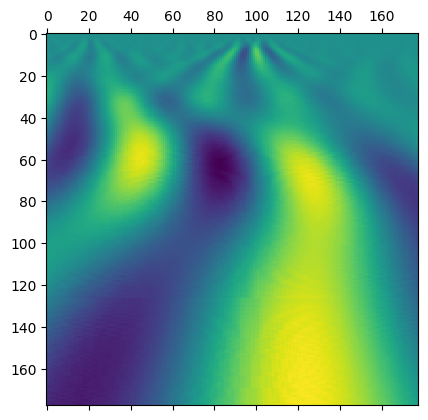

In [8]:
# Визуализируем сигнал, трансформированный путем непрерывного вейвлет-преобразования
sample_signal = X_train.iloc[0].to_numpy()
coef, freq = pywt.cwt(sample_signal, scales=scales, wavelet='morl')
plt.matshow(coef)
plt.show()

# **PyTorch Model Training**

Epoch 10 val loss: 0.061
Epoch 10 val acc: 0.976
Epoch 10 val metric: 0.96
Find new best model on val with loss: 0.061, epoch: 10 !


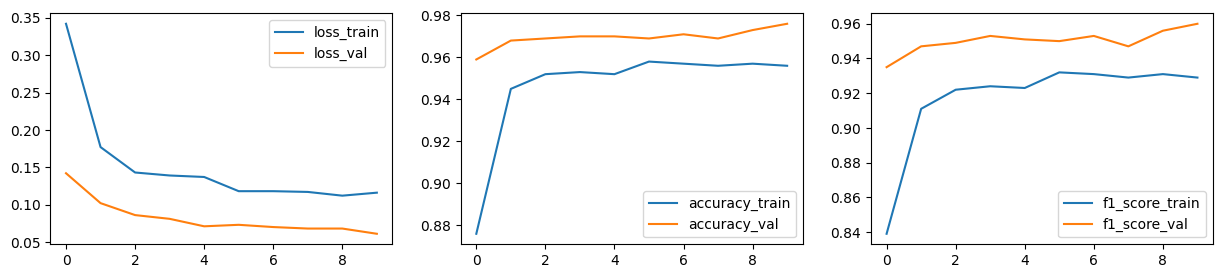

Best train loss: 0.112
Best val loss: 0.061
Best train metric: 0.931
Best val metric: 0.96


In [48]:
# Выберем в качестве модели EfficientNet V2S
# Функция потерь - Кросс-энтропия (подходит для задачи классификации)
# Функция оптимизации - Adam, шаг обучения 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
efnet_v2s = get_efficientnet_v2_s_mod()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efnet_v2s.parameters(), lr=1.0e-3)

best_efnet_v2s, best_loss, best_metric = train_model(efnet_v2s,loss_func=loss,\
                                            train_dataloader=train_dataloader, \
                                            val_dataloader=val_dataloader,\
                                            optimizer=optimizer, n_epochs=10,\
                                            device=device,metric=f1_score,\
                                            )

In [10]:
# Создадим тестовый дадасет на основе описанного ранее класса ESRDataset
test_dataset = ESRDataset(X_test, Y_test, scales=scales, wavelet='morl')
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [59]:
# Предсказания для тестового датасета
preds = predict(best_efnet_v2s, test_dataloader, device)
print(classification_report(Y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1835
           1       0.96      0.93      0.94       465

    accuracy                           0.98      2300
   macro avg       0.97      0.96      0.97      2300
weighted avg       0.98      0.98      0.98      2300



Неплохой результат, но еще есть над чем эксперементировать...